# Env Setup

## Packages

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.6 MB 4.0 MB/s 
     |████████████████████████████████| 636 kB 45.2 MB/s 
     |████████████████████████████████| 3.3 MB 49.9 MB/s 
     |████████████████████████████████| 895 kB 41.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import numpy as np
import pandas as pd

from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split
from sklearn import metrics

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers import AdamW
from transformers import BertConfig
from transformers import get_linear_schedule_with_warmup
from transformers import BertModel

from tqdm import tqdm
from tqdm.notebook import tqdm


from datetime import datetime
from dateutil.relativedelta import relativedelta

from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Mount Drive and Read Data

In [ ]:
import pandas as pd
import gzip
import json

def parse(path):
  g = open(path, 'rb')
  for l in g:
    yield json.loads(l)

def get_clean_df(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  
  df_ = pd.DataFrame.from_dict(df, orient='index')
  df = df_[['reviewText', 'overall']]
  df = df.drop_duplicates()
  df = df.dropna()

  return df


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_appliances = get_clean_df('/content/drive/My Drive/Amazon reviews dataset/Appliances_5.json')
df_giftcards = get_clean_df('/content/drive/My Drive/Amazon reviews dataset/Gift_Cards_5.json')
df_software = get_clean_df('/content/drive/My Drive/Amazon reviews dataset/Software_5.json')
df_arts = get_clean_df('/content/drive/My Drive/Amazon reviews dataset/Arts_Crafts_and_Sewing_5.json')
df_beauty = get_clean_df('/content/drive/My Drive/Amazon reviews dataset/All_Beauty_5.json')
df_magazine= get_clean_df('/content/drive/My Drive/Amazon reviews dataset/Magazine_Subscriptions_5.json')

In [ ]:
df_presampling = df_appliances.append(df_magazine)
df_presampling = df_presampling.append(df_software)
df_presampling = df_presampling.append(df_giftcards)
df_presampling = df_presampling.append(df_beauty)
df_presampling = df_presampling.append(df_arts)
df_presampling = df_presampling.drop_duplicates()

In [ ]:
df_presampling.overall.value_counts()

5.0    269794
4.0     50478
3.0     25206
1.0     13436
2.0     11608
Name: overall, dtype: int64

###Undersampling

In [ ]:
rus = RandomUnderSampler(random_state=0)

reviewText_array = np.reshape(df_presampling['reviewText'].values,(-1,1))
overall_array = np.reshape(df_presampling['overall'].values,(-1,1))

reviewText, overall = rus.fit_resample(reviewText_array, overall_array)
reviewText = reviewText.flatten()
overall = overall.flatten()

df = pd.DataFrame(list(zip(reviewText, overall)),columns=('reviewText','overall'))
df = df.drop_duplicates()
df.overall.value_counts()

3.0    11608
5.0    11608
4.0    11608
2.0    11608
1.0    11608
Name: overall, dtype: int64

# Classes & Functions

## Data Class

In [ ]:
class Bert_data_prep:
    def __init__(self,x, y, tokenizer, max_len = 256):
        self.x = x.values
        self.y = y.values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return(len(self.x))

    def __getitem__(self, item):
        x = self.x[item]
    
        x_encoded = tokenizer.encode_plus(x,
                                        add_special_tokens=True, 
                                        max_length = max_len, 
                                        pad_to_max_length = True, 
                                        return_tensors = 'pt'
                                        )  
        
        ids = x_encoded["input_ids"]
        mask = x_encoded["attention_mask"]
        token_type_ids = x_encoded["token_type_ids"]

        ids             = torch.squeeze(ids,0)
        mask            = torch.squeeze(mask,0)
        token_type_ids  = torch.squeeze(token_type_ids,0)

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.y[item], dtype=torch.long)
        }

## Test Data Class


In [ ]:
class test_data_prep:
    def __init__(self, x, tokenizer, max_len = 256):
        self.x = x.values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return(len(self.x))

    def __getitem__(self, item):
        x = self.x[item]
    
        x_encoded = tokenizer.encode_plus(x,
                                        add_special_tokens=True, 
                                        max_length = max_len, 
                                        pad_to_max_length = True, 
                                        return_tensors = 'pt'
                                        )  
        
        ids = x_encoded["input_ids"]
        mask = x_encoded["attention_mask"]
        token_type_ids = x_encoded["token_type_ids"]

        ids             = torch.squeeze(ids,0)
        mask            = torch.squeeze(mask,0)
        token_type_ids  = torch.squeeze(token_type_ids,0)

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long)
        }

## Custom BERT Network

In [ ]:
class BERTBaseUncased(nn.Module):
    def __init__(self):
        super(BERTBaseUncased, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.bert_drop = nn.Dropout()
        self.out = nn.Linear(768, 5) 
    
    def forward(self, ids, mask, token_type_ids):
        _, o2 = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids, return_dict=False)
        bo = self.bert_drop(o2)
        output = self.out(bo)
        return(output)

# Code Engine


## Data Prep

In [ ]:
df = df.sample(n=10000, random_state=1)
print(df.overall.value_counts())
len(df['reviewText'].values)

1.0    2102
2.0    2014
3.0    1970
5.0    1964
4.0    1950
Name: overall, dtype: int64


10000

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(df['reviewText'], df['overall'],train_size = 0.7,random_state = 1,stratify = df['overall'])

In [ ]:
test_x, valid_x, test_y, valid_y = train_test_split(test_x, test_y , train_size = 0.5, random_state = 1, stratify = test_y)

In [ ]:
print(train_y.value_counts(),len(train_x))
print(test_y.value_counts(),len(test_x))
print(valid_y.value_counts(),len(valid_x))

1.0    1471
2.0    1410
3.0    1379
5.0    1375
4.0    1365
Name: overall, dtype: int64 7000
1.0    315
2.0    302
5.0    295
3.0    295
4.0    293
Name: overall, dtype: int64 1500
1.0    316
2.0    302
3.0    296
5.0    294
4.0    292
Name: overall, dtype: int64 1500


## Parameters

In [ ]:
max_str = max(df.reviewText, key = len)
max_str_index = list(df.reviewText).index(max_str)
max_len = 256

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

power = 4

train_batch_size = 2**power
valid_batch_size = 2**power

print(f'train_batch_size : {train_batch_size}')
print(f'valid_batch_size : {valid_batch_size}')

train_batch_size : 16
valid_batch_size : 16


## Convert to Bert Format

In [ ]:
train_df = Bert_data_prep(x = train_x, y = train_y-1, tokenizer = tokenizer, max_len = max_len)
valid_df = Bert_data_prep(x = valid_x, y = valid_y-1, tokenizer = tokenizer, max_len = max_len)
test_df = Bert_data_prep(x = test_x, y = test_y-1, tokenizer = tokenizer, max_len = max_len)

## Data *Loader*

In [ ]:
train_data_loader = torch.utils.data.DataLoader(train_df, batch_size=train_batch_size)
valid_data_loader = torch.utils.data.DataLoader(valid_df, batch_size=valid_batch_size)
test_data_loader = torch.utils.data.DataLoader(test_df, batch_size=valid_batch_size)

In [ ]:
model = BERTBaseUncased()
model.cuda()
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
epochs = 4 
total_steps = len(train_data_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer= optimizer, num_warmup_steps=0, num_training_steps= total_steps)

## Model Training

In [ ]:
device = torch.device('cuda:0')
model = model.to(device)
nl = '\n'

In [ ]:
start = datetime.now()
loss_f = nn.NLLLoss() 
sm = nn.Softmax(dim=1)
lsm = nn.LogSoftmax(dim=1)

loss_list = []
accuracy_list = []

for epoch in tqdm(range(epochs)):    
    model.train()
    for i, batch_train in tqdm(enumerate(train_data_loader), total=len(train_df)/train_batch_size):
        ids             = batch_train['ids']
        mask            = batch_train['mask']
        targets         = batch_train['targets'].type(torch.FloatTensor)
        token_type_ids  = batch_train['token_type_ids']           

        ids             = ids.to(device, dtype = torch.long)
        targets         = targets.to(device, dtype = torch.long)
        mask            = mask.to(device, dtype = torch.long)
        token_type_ids  = token_type_ids.to(device, dtype = torch.long) 

        optimizer.zero_grad()
        train_outputs = model(ids = ids, mask = mask, token_type_ids = token_type_ids)
        train_outputs = lsm(train_outputs)
        loss = loss_f(train_outputs, targets)
        loss.backward()

        optimizer.step()
        scheduler.step()    

    model.eval()
    with torch.no_grad():
        for j, batch_valid in enumerate(valid_data_loader):
            ids             = batch_valid['ids']
            mask            = batch_valid['mask']
            targets         = batch_valid['targets'].type(torch.FloatTensor)
            token_type_ids  = batch_valid['token_type_ids']

            ids             = ids.to(device, dtype = torch.long)
            targets         = targets.to(device, dtype = torch.float)
            targets         = targets.cpu().detach().numpy()
            mask            = mask.to(device, dtype = torch.long)
            token_type_ids  = token_type_ids.to(device, dtype = torch.long) 

            outputs = model(ids = ids, mask = mask, token_type_ids = token_type_ids) 
            outputs = sm(outputs)
            outputs = outputs.cpu().detach().numpy()
            outputs = np.argmax(outputs, axis=1)
           
        loss_list.append(loss.data)        
  
        accuracy_val = accuracy_score(outputs, targets)   
        accuracy_list.append(accuracy_val)

        print(f'{nl}Epoch : {epoch}, Loss : {loss.data} , Accuracy : {accuracy_val}') 

end = datetime.now()
time_elapsed = relativedelta(end, start)
print(f'{nl} time_elapsed : {time_elapsed}')
torch.save(model.state_dict(), 'model.pth')

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/437.5 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.



Epoch : 0, Loss : 0.7275646924972534 , Accuracy : 0.75


  0%|          | 0/437.5 [00:00<?, ?it/s]


Epoch : 1, Loss : 0.7053416967391968 , Accuracy : 0.75

 time_elapsed : relativedelta(minutes=+21, seconds=+31, microseconds=+132752)


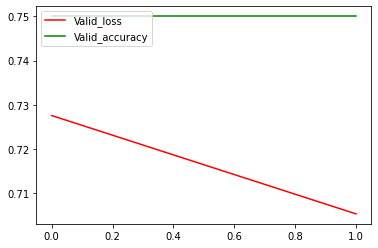

In [ ]:
plt.plot(np.array(loss_list), 'r', label='Valid_loss')
plt.plot(np.array(accuracy_list), 'g', label='Valid_accuracy')
plt.legend(loc="upper left")
plt.savefig('Validation', dpi=300)

## Testing

In [ ]:
accuracy_test_list = []
output_list = []
targets_list = []
for j, batch_valid in enumerate(test_data_loader):
            ids             = batch_valid['ids']
            mask            = batch_valid['mask']
            targets         = batch_valid['targets'].type(torch.FloatTensor)
            
            token_type_ids  = batch_valid['token_type_ids']

            ids             = ids.to(device, dtype = torch.long)
            targets         = targets.to(device, dtype = torch.float)
            targets         = targets.cpu().detach().numpy()
            targets_list.append(targets)
            mask            = mask.to(device, dtype = torch.long)
            token_type_ids  = token_type_ids.to(device, dtype = torch.long)            

            outputs = model(ids = ids, mask = mask, token_type_ids = token_type_ids) 
            outputs = sm(outputs)
            outputs = outputs.cpu().detach().numpy()
            output_list.append(outputs)
            outputs = np.argmax(outputs, axis=1)

            accuracy_test = accuracy_score(outputs, targets)
            accuracy_test_list.append(accuracy_test)

In [ ]:
len(accuracy_test_list)

94

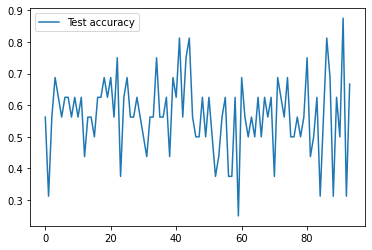

In [ ]:
nums = np.arange(0, len(accuracy_test_list), 20)
plt.plot(nums, [accuracy_test_list[i] for i in nums], label='Test accuracy')
# plt.plot(accuracy_test_list, label='Test accuracy')
plt.legend(loc="upper left")
plt.savefig('Test', dpi=300)

In [ ]:
# Accuracy on the test set
accuracy_test_list_ = np.array(accuracy_test_list)
averaged_acc = accuracy_test_list_.mean()
print(averaged_acc)

0.5695921985815603


In [ ]:
output_list = np.concatenate(output_list, axis=0)
output_list = np.argmax(output_list, axis=-1)

targets_list = np.concatenate(targets_list, axis=0)

In [ ]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

print(balanced_accuracy_score(targets_list, output_list))
print(classification_report(targets_list, output_list))
print(confusion_matrix(targets_list, output_list))

0.5678165852099946
              precision    recall  f1-score   support

         0.0       0.63      0.70      0.66       315
         1.0       0.49      0.47      0.48       302
         2.0       0.48      0.49      0.49       295
         3.0       0.52      0.41      0.46       293
         4.0       0.68      0.77      0.72       295

    accuracy                           0.57      1500
   macro avg       0.56      0.57      0.56      1500
weighted avg       0.56      0.57      0.56      1500

[[220  67  20   5   3]
 [ 89 143  62   8   0]
 [ 26  64 146  48  11]
 [  7  12  61 119  94]
 [  5   3  13  48 226]]


In [ ]:
test_df_ = test_df[- 4:]
results = [(x + 1) for x in outputs]
semantics = [(x + 1) for x in targets]
test_df_['Semantics'] = semantics
test_df_['Predicted rating'] = results
test_df_

# Zero-shot Classification

In [ ]:
test_df = get_clean_df('/content/drive/My Drive/Amazon reviews dataset/AMAZON_FASHION_5.json')
test_df2 = get_clean_df('/content/drive/My Drive/Amazon reviews dataset/Prime_Pantry_5.json')
test_df = test_df.append(test_df2)
test_df

,reviewText,overall
0,Great product and price!,5.0
5,Waaay too small. Will use for futur children!,3.0
6,Stays vibrant after many washes,5.0
8,My son really likes the pink. Ones which I was...,5.0
9,Waaay too small. Will use for future child.,3.0
...,...,...
137782,I like most of the flavors but this one is my ...,5.0
137784,These are delicious and healthy snacks! I wit...,4.0
137785,Taste not to be believed. Buy a box for my off...,5.0
137786,They are yummy!,5.0


In [ ]:
batch_size = len(test_df)
test_x, test_y = test_df['reviewText'], test_df['overall']
test_df_prep = Bert_data_prep(x = test_x, y = test_y-1, tokenizer = tokenizer, max_len = max_len)
test_data_loader = torch.utils.data.DataLoader(test_df_prep, batch_size=train_batch_size)

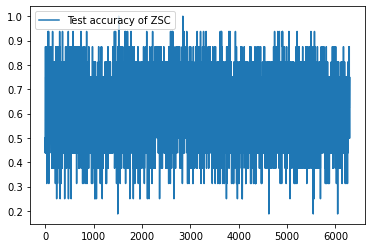

In [ ]:
accuracy_test_list = []
output_list = []
targets_list = []
for j, batch_valid in enumerate(test_data_loader):
            ids             = batch_valid['ids']
            mask            = batch_valid['mask']
            targets         = batch_valid['targets'].type(torch.FloatTensor)
            
            token_type_ids  = batch_valid['token_type_ids']

            ids             = ids.to(device, dtype = torch.long)
            targets         = targets.to(device, dtype = torch.float)
            targets         = targets.cpu().detach().numpy()
            targets_list.append(targets)
            mask            = mask.to(device, dtype = torch.long)
            token_type_ids  = token_type_ids.to(device, dtype = torch.long)            

            outputs = model(ids = ids, mask = mask, token_type_ids = token_type_ids) 
            outputs = sm(outputs)
            outputs = outputs.cpu().detach().numpy()
            output_list.append(outputs)
            outputs = np.argmax(outputs, axis=1)

            accuracy_test = accuracy_score(outputs, targets)
            accuracy_test_list.append(accuracy_test)


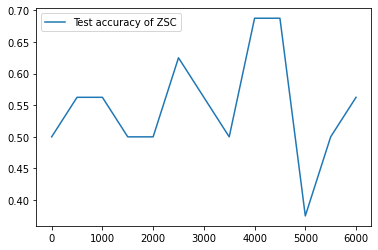

In [ ]:
nums = np.arange(0, len(accuracy_test_list), 500)
plt.plot(nums, [accuracy_test_list[i] for i in nums], label='Test accuracy of ZSC')
plt.legend(loc="upper left")
plt.savefig('Zero-shot classification', dpi=300)

In [ ]:
np.array(accuracy_test_list).mean()

0.6187172463077656

In [ ]:
output_list = np.concatenate(output_list, axis=0)
output_list = np.argmax(output_list, axis=-1)

targets_list = np.concatenate(targets_list, axis=0)

In [ ]:
print(balanced_accuracy_score(targets_list, output_list))
print(classification_report(targets_list, output_list))
print(confusion_matrix(targets_list, output_list))

0.5211142898062647
              precision    recall  f1-score   support

         0.0       0.29      0.60      0.39      2973
         1.0       0.27      0.45      0.34      3416
         2.0       0.32      0.45      0.37      7938
         3.0       0.28      0.42      0.34     15960
         4.0       0.90      0.69      0.78     70453

    accuracy                           0.62    100740
   macro avg       0.41      0.52      0.44    100740
weighted avg       0.72      0.62      0.65    100740

[[ 1784   819   250    71    49]
 [  989  1527   703   153    44]
 [  728  1834  3538  1489   349]
 [  394   554  3161  6712  5139]
 [ 2240   909  3385 15149 48770]]
